<center>
<img src="" width=600>
</center>
<div style="padding:20px;color:#150d0a;margin:10px;font-size:220%;text-align:center;display:fill;border-radius:20px;border-width: 5px;border-style: solid;border-color: #150d0a;background-color:#eca912;overflow:hidden;font-weight:500">DR Detection utilizing Deep Learning Models and XAI methods</div>

### <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
1. Importing libraries
2. MobileNet GNN Function
3. Load data
4. Training the MobileNet+GNN model
5. MobileNet + GNN Confusion Matrix
6. MobileNet + GNN Prediction
7. MobilNet + RNN Function
8. Training the MobileNet+RNN model
9. MobileNet + RNN Confusion Matrix
10. Grad-CAM Implementation
11. Layerwise Heatmaps

# Importing libraries 📚

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# MobileNet GNN Function

In [2]:
class GNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
    
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class MobileNetGNN(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetGNN, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet.classifier = nn.Identity()
        self.gnn_input_dim = 1280  
        self.gnn_hidden_dim = 512
        self.gnn_output_dim = num_classes
        self.gnn = GNNClassifier(self.gnn_input_dim, self.gnn_hidden_dim, self.gnn_output_dim)
    
    def forward(self, x, edge_index):
        features = self.mobilenet(x)
        features = features.view(features.size(0), -1)  
        edge_index = torch.tensor([[0, 1], [1, 0]], dtype=torch.long, device=x.device)
        output = self.gnn(features, edge_index)
        return output

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])


# Load data 💾

In [3]:
train_dataset = ImageFolder(root='Data/train', transform=transform)
val_dataset = ImageFolder(root='Data/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

num_classes = len(train_dataset.classes)


# Training the MobileNet+GNN model 🚂

In [4]:
model = MobileNetGNN(num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()
best_model_path = 'best_model.pth'
best_val_loss = float('inf')

C:\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
def accumulate_predictions_and_labels(loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0
    
    with torch.no_grad():
        for data, targets in loader:
            edge_index = torch.tensor([[0, 1], [1, 0]], dtype=torch.long, device=data.device)
            data, targets = data.to(next(model.parameters()).device), targets.to(next(model.parameters()).device)
            
            outputs = model(data, edge_index)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * data.size(0)
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
    
    avg_loss = total_loss / len(loader.dataset)
    avg_accuracy = accuracy_score(all_labels, all_preds)
    return np.array(all_labels), np.array(all_preds), avg_loss, avg_accuracy


def compute_accuracy(loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, targets in loader:
            edge_index = torch.tensor([[0, 1], [1, 0]], dtype=torch.long, device=data.device)
            data, targets = data.to(next(model.parameters()).device), targets.to(next(model.parameters()).device)
            
            outputs = model(data, edge_index)
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    
    return correct / total


for epoch in range(25):
    model.train()
    running_loss = 0.0
    for data, targets in train_loader:
        optimizer.zero_grad()
        
        edge_index = torch.tensor([[0, 1], [1, 0]], dtype=torch.long, device=data.device)
        data, targets = data.to(next(model.parameters()).device), targets.to(next(model.parameters()).device)
        
        outputs = model(data, edge_index)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * data.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = compute_accuracy(train_loader)
   
    y_true, y_pred, val_loss, val_acc = accumulate_predictions_and_labels(val_loader)
    
    print(f"Epoch {epoch+1}")
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch+1}")


cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred, target_names=val_dataset.classes)

print("Final Validation Metrics:")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(cr)

print("Training complete.")

Epoch 1
Training Loss: 1.7827, Training Accuracy: 0.1779
Validation Loss: 11.4179, Validation Accuracy: 0.2212
Best model saved at epoch 1
Epoch 2
Training Loss: 1.2748, Training Accuracy: 0.2510
Validation Loss: 3.0948, Validation Accuracy: 0.2903
Best model saved at epoch 2
Epoch 3
Training Loss: 0.9560, Training Accuracy: 0.4802
Validation Loss: 1.4231, Validation Accuracy: 0.4700
Best model saved at epoch 3
Epoch 4
Training Loss: 0.7204, Training Accuracy: 0.6482
Validation Loss: 1.1366, Validation Accuracy: 0.5945
Best model saved at epoch 4
Epoch 5
Training Loss: 0.5538, Training Accuracy: 0.7984
Validation Loss: 0.9258, Validation Accuracy: 0.7281
Best model saved at epoch 5
Epoch 6
Training Loss: 0.4612, Training Accuracy: 0.8715
Validation Loss: 0.6419, Validation Accuracy: 0.8111
Best model saved at epoch 6
Epoch 7
Training Loss: 0.4929, Training Accuracy: 0.7688
Validation Loss: 0.8009, Validation Accuracy: 0.7143
Epoch 8
Training Loss: 0.4066, Training Accuracy: 0.8261
Vali

# MobileNet + GNN Confusion Matrix

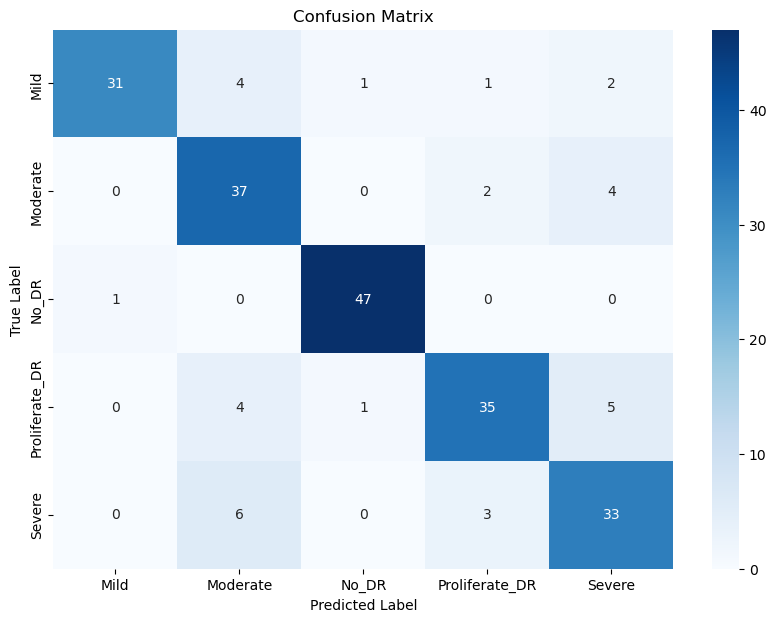

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred, target_names=val_dataset.classes)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix
class_names = val_dataset.classes
plot_confusion_matrix(cm, class_names)



# MobileNet+GNN Prediction

Predicted class: Proliferate_DR


C:\Users\Aditya\AppData\Local\Temp\ipykernel_5496\1513600729.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


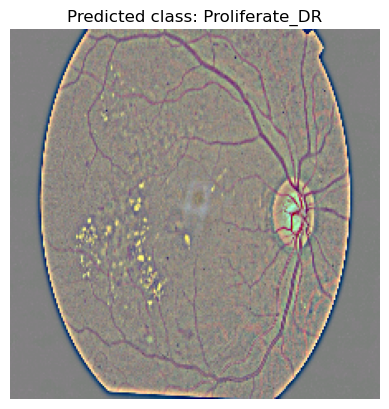

In [19]:
from PIL import Image
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

num_classes = len(ImageFolder(root='Data/train').classes)
model = MobileNetGNN(num_classes)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  
    return image

image_path = r'Data\val\Proliferate_DR\e39b627cf648.png'
image = preprocess_image(image_path)

device = torch.device('cpu')
model.to(device)
image = image.to(device)

num_nodes = 1
edge_index = torch.tensor([[0, 0], [0, 0]], dtype=torch.long, device=device)

with torch.no_grad():
    output = model(image, edge_index)
    _, predicted_class = torch.max(output, 1)

class_idx = predicted_class.item()
class_names = ImageFolder(root='Data/train').classes
predicted_label = class_names[class_idx]

print(f'Predicted class: {predicted_label}')

image = image.squeeze().permute(1, 2, 0).numpy()  
plt.imshow(image)
plt.title(f'Predicted class: {predicted_label}')
plt.axis('off')
plt.show()


# MobilNet + RNN Function

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np


class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        out = self.fc(rnn_out[:, -1, :])
        return F.log_softmax(out, dim=1)

class MobileNetRNN(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetRNN, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet.classifier = nn.Identity()
        
        self.feature_dim = 1280  
        self.rnn_input_dim = 1280
        self.rnn_hidden_dim = 512
        self.rnn_output_dim = num_classes
        
        self.rnn = RNNClassifier(self.rnn_input_dim, self.rnn_hidden_dim, self.rnn_output_dim)
    
    def forward(self, x):
        features = self.mobilenet(x)
        features = features.view(features.size(0), -1) 
        features = features.unsqueeze(1) 
        output = self.rnn(features)
        return output


# Load data 💾

In [16]:

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

train_dataset = ImageFolder(root='Data/train', transform=transform)
val_dataset = ImageFolder(root='Data/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

num_classes = len(train_dataset.classes)


# Training MobileNet+RNN model

In [17]:
model = MobileNetRNN(num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()
best_model_path = 'best_model_rnn.pth'
best_val_loss = float('inf')

In [18]:
def accumulate_predictions_and_labels(loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0
    
    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(next(model.parameters()).device), targets.to(next(model.parameters()).device)
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * data.size(0)
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
    
    avg_loss = total_loss / len(loader.dataset)
    avg_accuracy = accuracy_score(all_labels, all_preds)
    return np.array(all_labels), np.array(all_preds), avg_loss, avg_accuracy


def compute_accuracy(loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(next(model.parameters()).device), targets.to(next(model.parameters()).device)
            
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    
    return correct / total

for epoch in range(15):
    model.train()
    running_loss = 0.0
    for data, targets in train_loader:
        optimizer.zero_grad()
        
        data, targets = data.to(next(model.parameters()).device), targets.to(next(model.parameters()).device)
        
        outputs = model(data)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * data.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = compute_accuracy(train_loader)
    
    y_true, y_pred, val_loss, val_acc = accumulate_predictions_and_labels(val_loader)
    
    print(f"Epoch {epoch+1}")
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch+1}")

cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred, target_names=val_dataset.classes)

print("Final Validation Metrics:")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(cr)

print("Training complete.")

Epoch 1
Training Loss: 1.5209, Training Accuracy: 0.1798
Validation Loss: 3.2289, Validation Accuracy: 0.2212
Best model saved at epoch 1
Epoch 2
Training Loss: 0.9996, Training Accuracy: 0.4348
Validation Loss: 1.9026, Validation Accuracy: 0.4470
Best model saved at epoch 2
Epoch 3
Training Loss: 0.8711, Training Accuracy: 0.4664
Validation Loss: 1.6077, Validation Accuracy: 0.4424
Best model saved at epoch 3
Epoch 4
Training Loss: 0.7417, Training Accuracy: 0.6542
Validation Loss: 1.0064, Validation Accuracy: 0.6221
Best model saved at epoch 4
Epoch 5
Training Loss: 0.5864, Training Accuracy: 0.7273
Validation Loss: 1.0123, Validation Accuracy: 0.6544
Epoch 6
Training Loss: 0.3590, Training Accuracy: 0.7964
Validation Loss: 1.0249, Validation Accuracy: 0.7143
Epoch 7
Training Loss: 0.3482, Training Accuracy: 0.8913
Validation Loss: 0.7141, Validation Accuracy: 0.7558
Best model saved at epoch 7
Epoch 8
Training Loss: 0.3341, Training Accuracy: 0.8933
Validation Loss: 0.6449, Validati

# Confusion Matrix

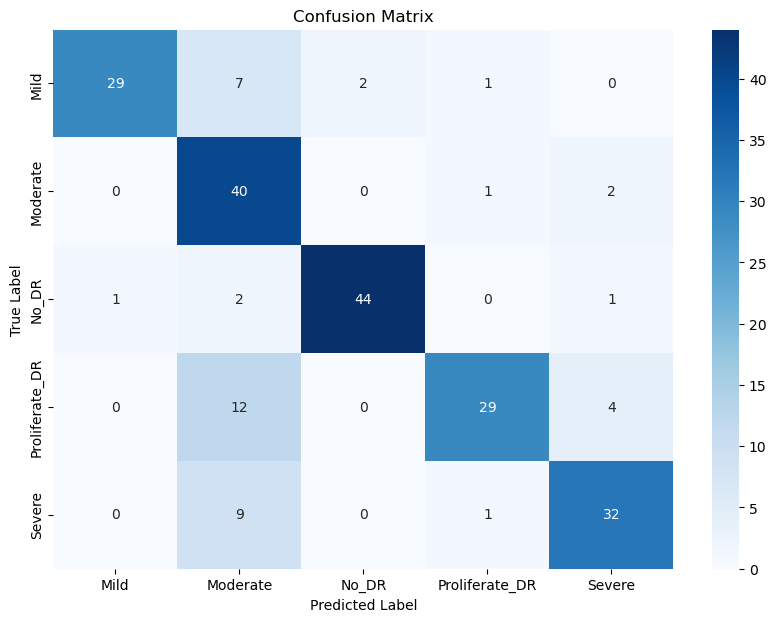

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred, target_names=val_dataset.classes)

# Define function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix
class_names = val_dataset.classes
plot_confusion_matrix(cm, class_names)




# Grad-CAM Implementation

In [7]:
model = MobileNetGNN(num_classes)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

C:\Users\Aditya\AppData\Local\Temp\ipykernel_16528\3435129339.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


MobileNetGNN(
  (mobilenet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size

In [8]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

def get_last_conv_layer(model):
    last_conv = None
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            last_conv = name
    return last_conv

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer6
        self.activations = None
        self.gradients = None
        for name, module in self.model.named_modules():
            if name == target_layer:
                module.register_forward_hook(self.save_activation)
                module.register_backward_hook(self.save_gradient)
                break
    
    def save_activation(self, module, input, output):
        self.activations = output
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
    
    def __call__(self, x, edge_index, class_idx=None):
        x = x.requires_grad_(True)
        self.model.eval()
        output = self.model(x, edge_index)
        if class_idx is None:
            class_idx = output.argmax(dim=1)
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = F.relu(cam) 
        cam = F.interpolate(cam, size=x.shape[2:], mode='bilinear', align_corners=False)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-7)
        
        return cam.detach().cpu().numpy()[0, 0]

def preprocess_image(image_path, size=(224, 224)):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(size)
    img_array = np.array(image) / 255.0
    tensor = torch.from_numpy(img_array).permute(2, 0, 1).float()
    tensor = tensor.unsqueeze(0)
    return tensor, img_array

def create_edge_index(size=224):
    edge_index = []
    for i in range(size):
        for j in range(size):
            node = i * size + j
            if j < size - 1:
                edge_index.extend([[node, node + 1], [node + 1, node]])
            if i < size - 1:
                edge_index.extend([[node, node + size], [node + size, node]])
    
    return torch.tensor(edge_index, dtype=torch.long).t()

def visualize_gradcam(image_path, model, target_layer=None, class_idx=None):
    if target_layer is None:
        target_layer = get_last_conv_layer(model)
        print(f"Using target layer: {target_layer}")

    grad_cam = GradCAM(model, target_layer)
    input_tensor, original_image = preprocess_image(image_path)
    edge_index = create_edge_index()
    if torch.cuda.is_available():
        input_tensor = input_tensor.cuda()
        edge_index = edge_index.cuda()
    heatmap = grad_cam(input_tensor, edge_index, class_idx)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed = (original_image * 0.6 + heatmap / 255.0 * 0.4)
    superimposed = np.clip(superimposed, 0, 1)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax1.imshow(original_image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    ax2.imshow(heatmap)
    ax2.set_title('Grad-CAM Heatmap')
    ax2.axis('off')
    
    ax3.imshow(superimposed)
    ax3.set_title('Superimposed')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

Using target layer: mobilenet.features.18.0


C:\Anaconda\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


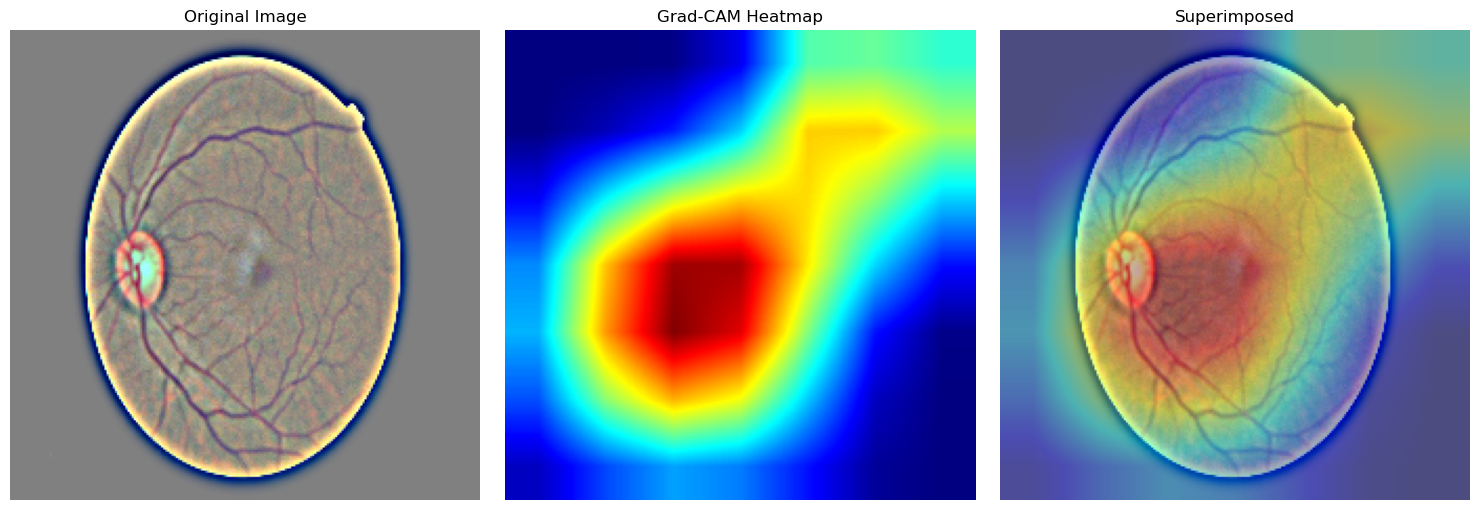

Using target layer: mobilenet.features.18.0


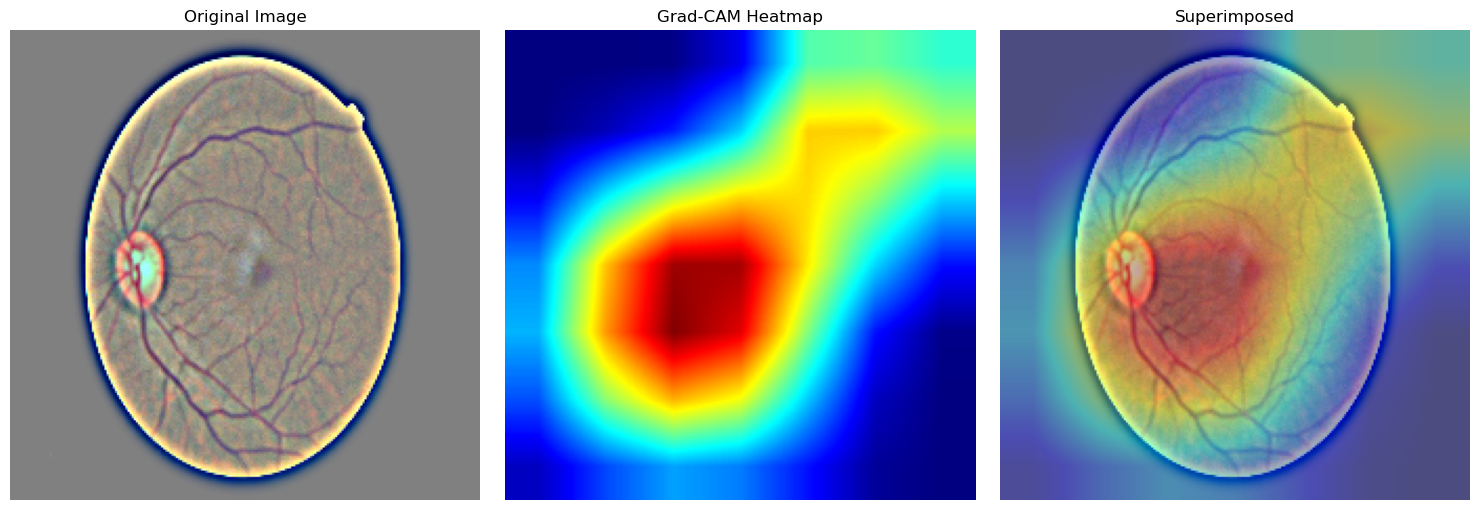

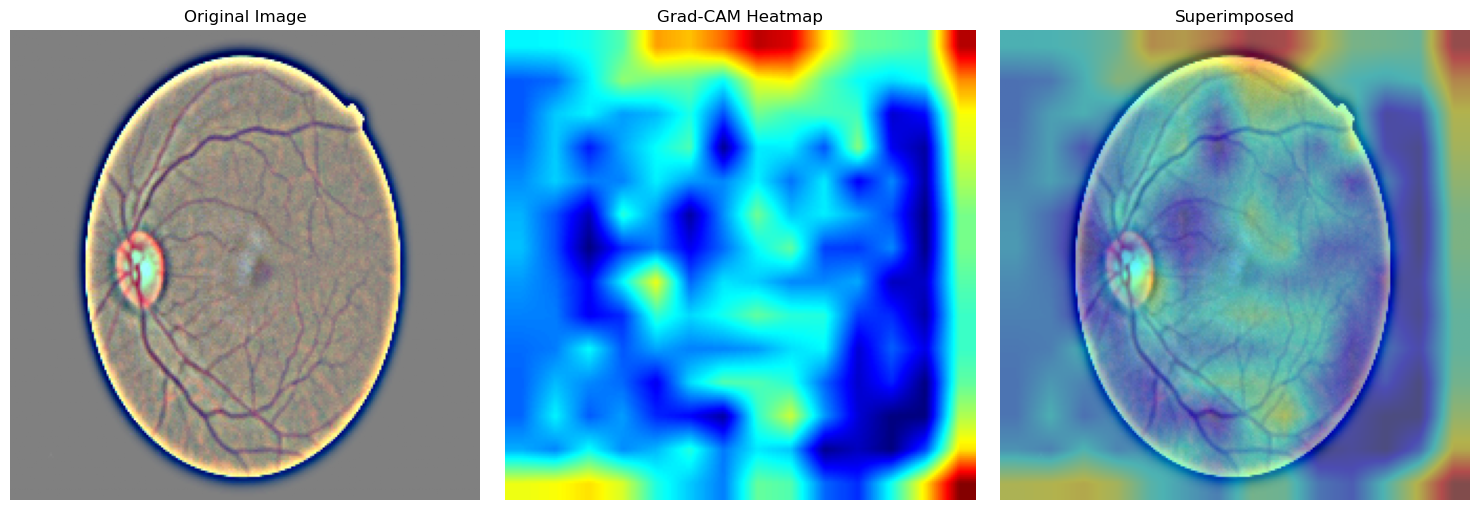

In [9]:

image_path = 'Data/val/No_DR/cb28adab4e8a.png'

visualize_gradcam(image_path, model)

visualize_gradcam(image_path, model)

target_layer = "mobilenet.features.8.conv.2"
visualize_gradcam(image_path, model, target_layer=target_layer)

# Layerwise Heatmaps

C:\Users\Aditya\AppData\Local\Temp\ipykernel_16528\3696887727.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


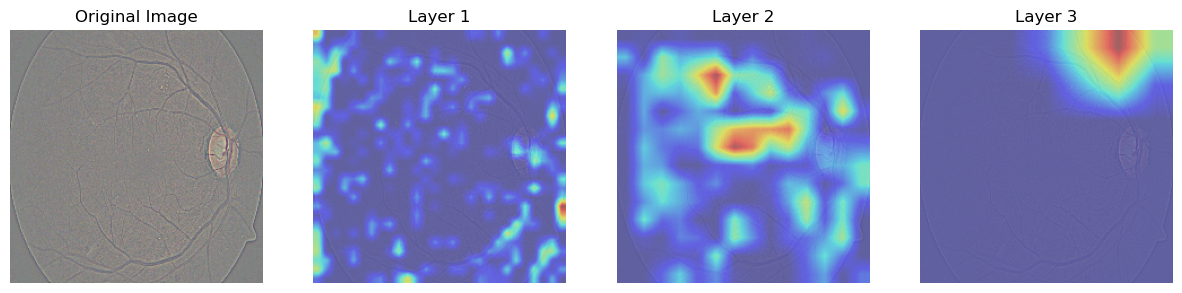

In [10]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
from torchvision.datasets import ImageFolder

num_classes = len(ImageFolder(root='Data/val').classes)
model = MobileNetGNN(num_classes)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

class GradCAM:
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []
        self.activations = []
        self.hooks = []
        self.register_hooks()

    def register_hooks(self):
        for layer in self.target_layers:
            self.hooks.append(layer.register_forward_hook(self.forward_hook))
            self.hooks.append(layer.register_backward_hook(self.backward_hook))

    def forward_hook(self, module, input, output):
        self.activations.append(output)

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients.append(grad_output[0])

    def generate_heatmap(self, image, class_idx):
        self.activations = []
        self.gradients = []
        image = image.to(device)
        output = self.model(image, edge_index)  
        self.model.zero_grad()
        one_hot_output = torch.zeros_like(output)
        one_hot_output[0, class_idx] = 1
        output.backward(gradient=one_hot_output)
        heatmaps = []
        for activation, gradient in zip(self.activations, self.gradients):
            B, C_act, H, W = activation.shape  
            B, C_grad, _, _ = gradient.shape 
            weights = torch.mean(gradient, dim=[2, 3], keepdim=True) 
            if C_grad != C_act:
                weights = F.interpolate(weights, size=(H, W), mode='bilinear', align_corners=False)

            C_final = min(C_act, C_grad) 
            cam = F.relu(torch.sum(weights[:, :C_final] * activation[:, :C_final], dim=1))  
            cam = cam.cpu().detach().numpy()
            cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8) 
            cam = cv2.resize(cam[0], (224, 224))  
            heatmaps.append(cam)

        return heatmaps

cam = GradCAM(model, [model.mobilenet.features[6], model.mobilenet.features[13], model.mobilenet.features[17]])

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image

image_path = 'Data/train/Severe/7a6e384a0846.png'
image = preprocess_image(image_path).to(device)

with torch.no_grad():
    output = model(image, edge_index)
    _, predicted_class = torch.max(output, 1)
    class_idx = predicted_class.item()

heatmaps = cam.generate_heatmap(image, class_idx)

fig, axes = plt.subplots(1, len(heatmaps) + 1, figsize=(15, 5))
axes[0].imshow(Image.open(image_path))
axes[0].set_title('Original Image')
axes[0].axis('off')

for i, heatmap in enumerate(heatmaps):
    axes[i+1].imshow(Image.open(image_path), alpha=0.5)
    axes[i+1].imshow(heatmap, cmap='jet', alpha=0.5)
    axes[i+1].set_title(f'Layer {i+1}')
    axes[i+1].axis('off')

plt.show()

In [ ]:
# import torch
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# import numpy as np

# def evaluate_model(model, data_loader, device):
#     model.eval()
#     all_predictions = []
#     all_labels = []
    
#     with torch.no_grad():
#         for images, labels in data_loader:
#             images = images.to(device)
#             edge_index = create_edge_index().to(device)  # Using the existing create_edge_index function
#             outputs = model(images, edge_index)
#             _, predicted = torch.max(outputs.data, 1)
#             all_predictions.extend(predicted.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     all_predictions = np.array(all_predictions)
#     all_labels = np.array(all_labels)
#     accuracy = accuracy_score(all_labels, all_predictions)
#     precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
#     per_class_precision, per_class_recall, per_class_f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average=None)
    
#     metrics = {
#         'accuracy': accuracy,
#         'precision': precision,
#         'recall': recall,
#         'f1_score': f1,
#         'per_class_precision': per_class_precision,
#         'per_class_recall': per_class_recall,
#         'per_class_f1': per_class_f1
#     }
#     return metrics

# def get_data_loader(data_dir, batch_size=32):
#     transform = transforms.Compose([
#         transforms.Resize(224),
#         transforms.CenterCrop(224),
#         transforms.ToTensor()
#     ])
    
#     dataset = datasets.ImageFolder(root=data_dir, transform=transform)
#     data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
#     return data_loader, dataset.classes

# def main():
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     num_classes = len(ImageFolder(root='Data/val').classes)
#     model = MobileNetGNN(num_classes)
#     model.load_state_dict(torch.load('best_model.pth'))
#     model.to(device)
#     val_loader, class_names = get_data_loader('Data/val')
#     metrics = evaluate_model(model, val_loader, device)

#     print("\nOverall Metrics:")
#     print(f"Accuracy: {metrics['accuracy']:.4f}")
#     print(f"Precision: {metrics['precision']:.4f}")
#     print(f"Recall: {metrics['recall']:.4f}")
#     print(f"F1-Score: {metrics['f1_score']:.4f}")
    
#     print("\nPer-class Metrics:")
#     for i, class_name in enumerate(class_names):
#         print(f"\n{class_name}:")
#         print(f"Precision: {metrics['per_class_precision'][i]:.4f}")
#         print(f"Recall: {metrics['per_class_recall'][i]:.4f}")
#         print(f"F1-Score: {metrics['per_class_f1'][i]:.4f}")

# if __name__ == "__main__":
#     main()